# Homework Assignment 7

In [1]:
import matplotlib.pyplot as plt
import spacy
from collections import Counter
import pandas as pd
import networkx as nx
import operator
import re
import turicreate as tc
from afinn import Afinn
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
import gensim
import numpy as np

/data/home/yuvalhef/anaconda3/envs/venv/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


**Question 1:** Select a book and construct a network of people and locations (20pt). Visualize the network using Cytoscape or Gephi (20pt).


**My Note:**
I chose the Dickens book - The Uncommercial Traveller.
I defined a dircted graph in which each person and location in a paragraph are defined as an edge directed from the person to the location. For visualization purposes I defined a graph of only the top mentioned locations.

In [157]:
nlp = spacy.load('en_core_web_lg')

# Load the The book
path = "dickens/914-0.txt"

from tqdm import tqdm
txt = open(path).read()
paragraphs_list = txt.split("\n\n")

def persons_locations_edges(txt):
    links_set = set()
    doc = nlp(txt)
    p = [entity.text.lower().strip() for entity in doc.ents if entity.label_ == "PERSON"]
    l = [entity.text.lower().strip() for entity in doc.ents if entity.label_ == "GPE"] # I found GPE to work better than LOC
    
    for e1 in p:
        for e2 in l:
            if e1 == e2 or len(e1) < 2 or len(e2)< 2:
                continue
            links_set.add((e1,e2))
    return links_set

def set2nxDigraph(links):
    # creates the directed graph from links
    g = nx.DiGraph()
    for e,count in dict(c).items():
        v1,v2 = e
        g.add_edge(v1,v2, weight=count)
        g.nodes[v1]['type'] = 'person'
        g.nodes[v2]['type'] = 'location'
    return g

def get_top_loc_graph(ng, num_locations):
    # creates a subgraph with top locations and the persons connected to these locations
    sorted_nodes = sorted(dict(ng.in_degree).items(), key=operator.itemgetter(1))[::-1]
    top_locations = [x for (x, y) in sorted_nodes[:num_locations]]
    top_g = nx.DiGraph()
    for edge in ng.edges:
        if not edge[1] in top_locations:
            continue
        v1,v2 = edge
        top_g.add_edge(v1,v2)
        top_g.nodes[v1]['type'] = 'person'
        top_g.nodes[v2]['type'] = 'location'
    return top_g

# Create the graph edges 
edges = []    
for para in tqdm(paragraphs_list):
    edges += list(persons_locations_edges(para))

# Cretae the directed graph fron the edges
ng = set2nxDigraph(edges)

# Create the sub-graph for better visualization
top_loc_ng = get_top_loc_graph(ng, 15)

# Write to gml file for Cytoscape
nx.write_gml(top_loc_ng, 'book1.gml')

100%|██████████| 1344/1344 [00:29<00:00, 45.15it/s]


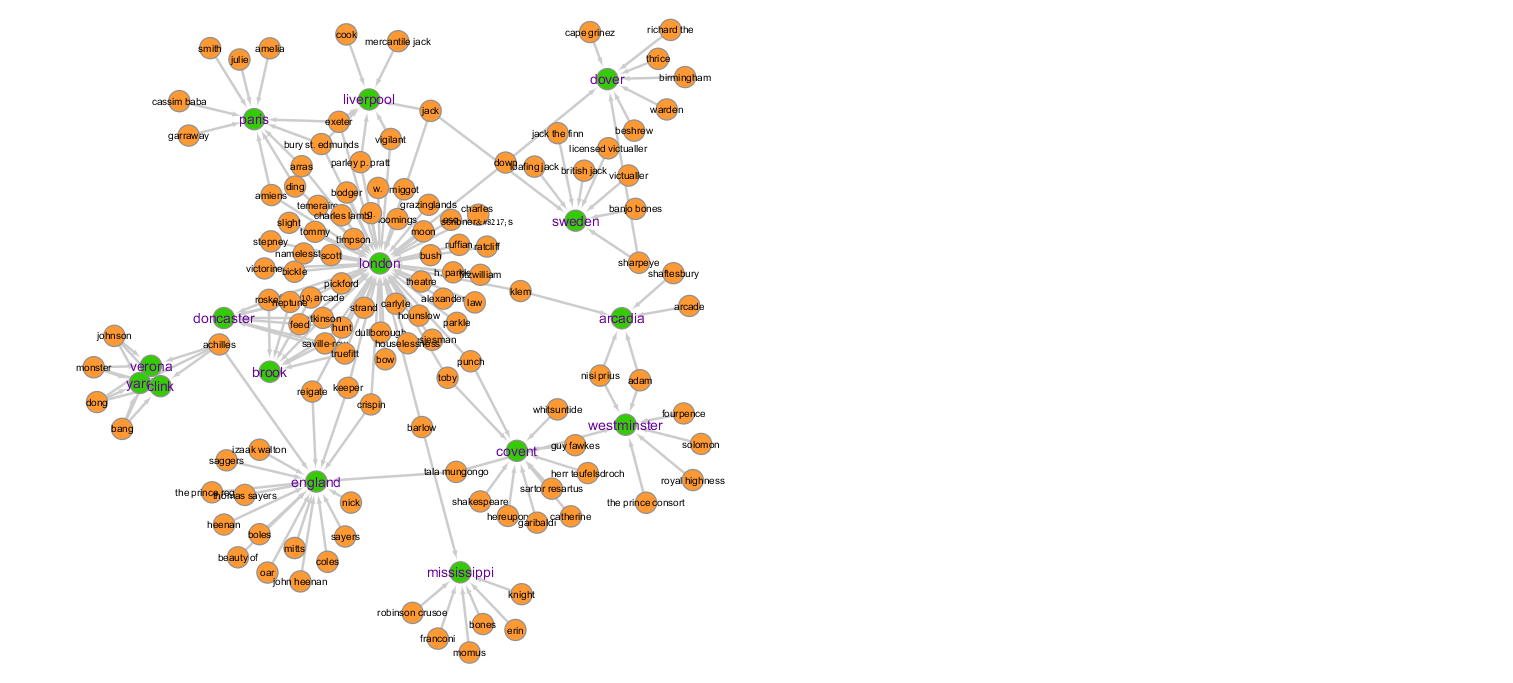

In [334]:
# The following output is the visualized graph in Cytoscape. Location nodes in green and person nodes in orange.

from IPython.display import Image
Image(filename="book1.png")

**Question 2:** Use the [Seinfeld Text corpus](https://www.kaggle.com/luongleanstocode/seinfeld-text-corpus)
to create a weighted social networks of Seinfeld characters. 
Visualize the number of lines each character of the show said (only for the main characters) (20pt).
Create a classifier that given a line of text can predict
 if the line was said by Jerry, Elaine, George, or Kramer (30pt).
Evaluate your classifier (10pt).

**My Note:**
Each edge (link) in the graph is defined by the participation of 2 characters in a scene.

In [10]:
# Load the The seinfeld corpus
path = "corpus.txt"
txt = open(path, 'r+', encoding="utf-8").read()

# Split the text to the different scenes
scenes = re.sub(r'\nINT\. (.*)\n|\nEXT\. (.*)\n|\n\[INT\. (.*)\n|\n\[EXT\. (.*)\n|\n\[(.*)\]', 'SCENE_Y\n', txt)
scenes_list = scenes.split("SCENE_Y\n")[1:]

print('Number of scenes in the corpus: {}'.format(len(scenes_list)))

Number of scenes in the corpus: 3434


In [11]:
scenes_list[102]

"(Harold and Manny are arguing.)\nHAROLD: I'm not going.\n(Manny says something in Spanish. Jerry enters the hallway.)\nJERRY: Boys, boys.\nHAROLD: Oh, Jerry.\nJERRY: I slid the rent under your door, Harold. Did you get it?\nHAROLD: Yeah, yeah... Hey, Jerry, would you like anything from Mrs. Hudwalker's apartment?\nMANNY: (in Spanish) You can't give him anything from there!\nHAROLD: I was only joking. (to Jerry) He thinks I'm gonna give you Mrs. Hudwalker's things.\nMANNY: (in Spanish) You offered them to him.\nHAROLD: (to Jerry) We have to go up there now and clean the apartment. It's a good thing her rent was overdue. She'd be rotting up there for a month.\nJERRY: She died? Mrs. Hudwalker died?\nHAROLD: Ninety-four years old. I found her yesterday. She didn't have her wig on. It was horrifying.\nMANNY: (in Spanish) Harold, Come on, hurry up!\nHAROLD: (to Manny) What's the matter with you? I'm talking! So, Jerry, you know anyone who needs an apartment?\nJERRY: Are you kidding? You kno

In [183]:
# Common names that stand for the same person
name_dict = {
    'jerry':['jerry)', 'jerry seinfeld', 'seinfeld'],
    'kramer':['cosmo', 'cosmo kramer'],
    'george':['george)', 'george.','george costanza', 'costanza', 'georgie'],
    'elaine':['elaine benes', 'benes']
}


def get_persons_links(txt):
    # Creates the links given in a text doc
    links_set = set()
    doc = nlp(txt)
    l = [entity.text.lower().strip() for entity in doc.ents if entity.label_ == "PERSON"]
    
    for e1 in l:
        for e2 in l:
            # if name has different form, transform to the basic form:
            for name, names in name_dict.items(): 
                if e1 in names:
                    e1 = name
                if e2 in names:
                    e2 = name
            if e1 == e2 or len(e1) < 2 or len(e2)< 2:
                continue
            if e1 > e2:
                e1, e2 = e2, e1 # switch order
            links_set.add((e1,e2))

    return links_set

# Create the links by going through the scenes
links_list = []    
for para in tqdm(scenes_list):
    links_list += list(get_persons_links(para))





  0%|          | 0/3434 [00:00<?, ?it/s]



  0%|          | 1/3434 [00:00<09:07,  6.27it/s]



  0%|          | 3/3434 [00:00<07:32,  7.58it/s]



  0%|          | 4/3434 [00:00<07:18,  7.83it/s]



  0%|          | 5/3434 [00:00<07:01,  8.14it/s]



  0%|          | 7/3434 [00:00<06:15,  9.13it/s]



  0%|          | 9/3434 [00:00<05:42, 10.00it/s]



  0%|          | 11/3434 [00:00<05:08, 11.10it/s]



  0%|          | 13/3434 [00:01<05:05, 11.20it/s]



  0%|          | 15/3434 [00:01<04:59, 11.41it/s]



  0%|          | 17/3434 [00:01<05:33, 10.23it/s]



  1%|          | 19/3434 [00:01<05:14, 10.87it/s]



  1%|          | 21/3434 [00:01<05:16, 10.80it/s]



  1%|          | 23/3434 [00:02<04:58, 11.44it/s]



  1%|          | 25/3434 [00:02<04:36, 12.33it/s]



  1%|          | 27/3434 [00:02<05:35, 10.17it/s]



  1%|          | 29/3434 [00:02<05:18, 10.68it/s]



  1%|          | 32/3434 [00:02<04:25, 12.79it/s]



  1%|          | 34/3434 [00:02<04:15, 13.30it/s]



  1%

 10%|█         | 346/3434 [00:22<03:45, 13.70it/s]



 10%|█         | 350/3434 [00:22<03:03, 16.77it/s]



 10%|█         | 353/3434 [00:22<03:44, 13.72it/s]



 10%|█         | 356/3434 [00:22<03:31, 14.54it/s]



 10%|█         | 359/3434 [00:23<03:10, 16.15it/s]



 11%|█         | 362/3434 [00:23<02:45, 18.53it/s]



 11%|█         | 366/3434 [00:23<02:26, 20.97it/s]



 11%|█         | 371/3434 [00:23<02:01, 25.24it/s]



 11%|█         | 375/3434 [00:23<01:48, 28.13it/s]



 11%|█         | 380/3434 [00:23<01:37, 31.23it/s]



 11%|█         | 384/3434 [00:24<02:23, 21.19it/s]



 11%|█▏        | 387/3434 [00:24<02:22, 21.40it/s]



 11%|█▏        | 390/3434 [00:24<02:47, 18.22it/s]



 11%|█▏        | 393/3434 [00:24<03:13, 15.70it/s]



 12%|█▏        | 395/3434 [00:24<03:29, 14.50it/s]



 12%|█▏        | 397/3434 [00:24<03:15, 15.50it/s]



 12%|█▏        | 399/3434 [00:25<03:23, 14.88it/s]



 12%|█▏        | 402/3434 [00:25<02:59, 16.92it/s]



 12%|█▏        | 406/3434 [0

 22%|██▏       | 753/3434 [00:45<03:14, 13.79it/s]



 22%|██▏       | 755/3434 [00:45<03:21, 13.30it/s]



 22%|██▏       | 757/3434 [00:45<03:22, 13.20it/s]



 22%|██▏       | 759/3434 [00:45<03:48, 11.70it/s]



 22%|██▏       | 761/3434 [00:45<03:57, 11.24it/s]



 22%|██▏       | 764/3434 [00:45<03:14, 13.71it/s]



 22%|██▏       | 766/3434 [00:46<03:04, 14.45it/s]



 22%|██▏       | 768/3434 [00:46<03:38, 12.22it/s]



 22%|██▏       | 771/3434 [00:46<03:03, 14.54it/s]



 23%|██▎       | 775/3434 [00:46<02:30, 17.72it/s]



 23%|██▎       | 778/3434 [00:46<02:27, 18.01it/s]



 23%|██▎       | 781/3434 [00:46<03:04, 14.35it/s]



 23%|██▎       | 783/3434 [00:47<03:05, 14.28it/s]



 23%|██▎       | 786/3434 [00:47<02:56, 15.00it/s]



 23%|██▎       | 789/3434 [00:47<02:43, 16.16it/s]



 23%|██▎       | 793/3434 [00:47<02:23, 18.40it/s]



 23%|██▎       | 796/3434 [00:47<02:09, 20.30it/s]



 23%|██▎       | 801/3434 [00:47<01:51, 23.67it/s]



 23%|██▎       | 804/3434 [0

 35%|███▍      | 1189/3434 [01:04<01:24, 26.61it/s]



 35%|███▍      | 1193/3434 [01:05<01:26, 25.94it/s]



 35%|███▍      | 1196/3434 [01:05<01:32, 24.11it/s]



 35%|███▍      | 1199/3434 [01:05<01:30, 24.79it/s]



 35%|███▌      | 1202/3434 [01:05<01:45, 21.07it/s]



 35%|███▌      | 1205/3434 [01:05<01:59, 18.68it/s]



 35%|███▌      | 1208/3434 [01:05<01:54, 19.37it/s]



 35%|███▌      | 1211/3434 [01:06<01:59, 18.54it/s]



 35%|███▌      | 1213/3434 [01:06<02:01, 18.22it/s]



 35%|███▌      | 1217/3434 [01:06<01:51, 19.81it/s]



 36%|███▌      | 1220/3434 [01:06<01:40, 22.03it/s]



 36%|███▌      | 1223/3434 [01:06<02:01, 18.20it/s]



 36%|███▌      | 1226/3434 [01:06<02:15, 16.32it/s]



 36%|███▌      | 1228/3434 [01:07<02:09, 17.01it/s]



 36%|███▌      | 1235/3434 [01:07<01:41, 21.73it/s]



 36%|███▌      | 1239/3434 [01:07<01:31, 24.08it/s]



 36%|███▌      | 1243/3434 [01:07<02:11, 16.66it/s]



 36%|███▋      | 1246/3434 [01:07<02:12, 16.57it/s]



 36%|███▋ 

 47%|████▋     | 1623/3434 [01:24<01:45, 17.14it/s]



 47%|████▋     | 1626/3434 [01:24<01:40, 17.91it/s]



 47%|████▋     | 1630/3434 [01:24<01:25, 21.16it/s]



 48%|████▊     | 1635/3434 [01:24<01:11, 25.25it/s]



 48%|████▊     | 1639/3434 [01:25<01:04, 27.66it/s]



 48%|████▊     | 1643/3434 [01:25<01:02, 28.62it/s]



 48%|████▊     | 1647/3434 [01:25<01:01, 28.93it/s]



 48%|████▊     | 1652/3434 [01:25<01:03, 28.16it/s]



 48%|████▊     | 1655/3434 [01:25<01:09, 25.54it/s]



 48%|████▊     | 1659/3434 [01:25<01:04, 27.71it/s]



 48%|████▊     | 1663/3434 [01:25<01:03, 27.90it/s]



 49%|████▊     | 1667/3434 [01:26<01:03, 27.96it/s]



 49%|████▊     | 1670/3434 [01:26<01:22, 21.31it/s]



 49%|████▊     | 1673/3434 [01:26<01:26, 20.39it/s]



 49%|████▉     | 1676/3434 [01:26<01:32, 18.97it/s]



 49%|████▉     | 1679/3434 [01:26<01:31, 19.12it/s]



 49%|████▉     | 1683/3434 [01:26<01:21, 21.50it/s]



 49%|████▉     | 1686/3434 [01:26<01:18, 22.37it/s]



 49%|████▉

 61%|██████▏   | 2108/3434 [01:43<01:06, 19.80it/s]



 62%|██████▏   | 2112/3434 [01:43<00:58, 22.59it/s]



 62%|██████▏   | 2115/3434 [01:43<01:01, 21.36it/s]



 62%|██████▏   | 2118/3434 [01:43<00:57, 22.72it/s]



 62%|██████▏   | 2123/3434 [01:44<00:55, 23.55it/s]



 62%|██████▏   | 2126/3434 [01:44<00:56, 22.98it/s]



 62%|██████▏   | 2131/3434 [01:44<00:49, 26.52it/s]



 62%|██████▏   | 2134/3434 [01:44<00:49, 26.13it/s]



 62%|██████▏   | 2137/3434 [01:44<00:47, 27.11it/s]



 62%|██████▏   | 2140/3434 [01:44<00:48, 26.75it/s]



 63%|██████▎   | 2147/3434 [01:44<00:40, 31.55it/s]



 63%|██████▎   | 2151/3434 [01:45<00:52, 24.32it/s]



 63%|██████▎   | 2154/3434 [01:45<00:49, 25.61it/s]



 63%|██████▎   | 2157/3434 [01:45<01:09, 18.42it/s]



 63%|██████▎   | 2160/3434 [01:45<01:07, 18.91it/s]



 63%|██████▎   | 2163/3434 [01:45<01:00, 20.94it/s]



 63%|██████▎   | 2167/3434 [01:45<00:53, 23.77it/s]



 63%|██████▎   | 2170/3434 [01:46<00:52, 24.22it/s]



 63%|█████

 76%|███████▋  | 2619/3434 [02:01<00:29, 27.73it/s]



 76%|███████▋  | 2624/3434 [02:01<00:26, 30.84it/s]



 77%|███████▋  | 2629/3434 [02:01<00:23, 34.23it/s]



 77%|███████▋  | 2633/3434 [02:01<00:30, 26.50it/s]



 77%|███████▋  | 2637/3434 [02:01<00:28, 28.13it/s]



 77%|███████▋  | 2641/3434 [02:01<00:26, 29.86it/s]



 77%|███████▋  | 2646/3434 [02:01<00:23, 33.15it/s]



 77%|███████▋  | 2650/3434 [02:01<00:22, 34.42it/s]



 77%|███████▋  | 2654/3434 [02:02<00:22, 34.58it/s]



 77%|███████▋  | 2659/3434 [02:02<00:21, 36.77it/s]



 78%|███████▊  | 2664/3434 [02:02<00:19, 39.17it/s]



 78%|███████▊  | 2669/3434 [02:02<00:22, 33.38it/s]



 78%|███████▊  | 2673/3434 [02:02<00:32, 23.62it/s]



 78%|███████▊  | 2678/3434 [02:02<00:27, 27.37it/s]



 78%|███████▊  | 2682/3434 [02:03<00:27, 27.80it/s]



 78%|███████▊  | 2687/3434 [02:03<00:25, 29.39it/s]



 78%|███████▊  | 2691/3434 [02:03<00:26, 27.59it/s]



 79%|███████▊  | 2696/3434 [02:03<00:24, 30.68it/s]



 79%|█████

 91%|█████████▏| 3139/3434 [02:18<00:08, 36.37it/s]



 92%|█████████▏| 3143/3434 [02:18<00:08, 32.75it/s]



 92%|█████████▏| 3147/3434 [02:18<00:11, 24.21it/s]



 92%|█████████▏| 3150/3434 [02:18<00:12, 21.88it/s]



 92%|█████████▏| 3153/3434 [02:18<00:12, 23.15it/s]



 92%|█████████▏| 3156/3434 [02:19<00:12, 22.64it/s]



 92%|█████████▏| 3159/3434 [02:19<00:12, 22.36it/s]



 92%|█████████▏| 3162/3434 [02:19<00:13, 20.76it/s]



 92%|█████████▏| 3165/3434 [02:19<00:14, 18.51it/s]



 92%|█████████▏| 3167/3434 [02:19<00:16, 16.40it/s]



 92%|█████████▏| 3170/3434 [02:19<00:14, 18.31it/s]



 92%|█████████▏| 3173/3434 [02:19<00:13, 19.53it/s]



 93%|█████████▎| 3177/3434 [02:20<00:11, 22.16it/s]



 93%|█████████▎| 3180/3434 [02:20<00:11, 22.95it/s]



 93%|█████████▎| 3184/3434 [02:20<00:09, 25.45it/s]



 93%|█████████▎| 3187/3434 [02:20<00:11, 20.70it/s]



 93%|█████████▎| 3190/3434 [02:20<00:13, 18.48it/s]



 93%|█████████▎| 3194/3434 [02:20<00:11, 20.52it/s]



 93%|█████

In [184]:
# Obtain the most common links (for visualization purposes)
c = Counter(links_list)
c.most_common(40)

[(('elaine', 'jerry'), 887),
 (('george', 'jerry'), 849),
 (('jerry', 'kramer'), 663),
 (('elaine', 'george'), 613),
 (('elaine', 'kramer'), 537),
 (('george', 'kramer'), 415),
 (('jerry', 'newman'), 108),
 (('george', 'susan'), 103),
 (('kramer', 'newman'), 77),
 (('helen', 'jerry'), 66),
 (('elaine', 'newman'), 60),
 (('elaine', 'peterman'), 56),
 (('estelle', 'frank'), 53),
 (('frank', 'george'), 53),
 (('jerry', 'morty'), 52),
 (('estelle', 'george'), 52),
 (('elaine', 'susan'), 50),
 (('jerry', 'susan'), 49),
 (('helen', 'morty'), 46),
 (('george', 'steinbrenner'), 45),
 (('elaine', 'puddy'), 41),
 (('george', 'newman'), 37),
 (('frank', 'kramer'), 30),
 (('elaine', 'pitt'), 29),
 (('elaine', 'lippman'), 28),
 (('george', 'wilhelm'), 27),
 (('jerry', 'leo'), 26),
 (('elaine', 'frank'), 25),
 (('david', 'elaine'), 25),
 (('bania', 'jerry'), 24),
 (('george', 'kruger'), 24),
 (('elaine', 'morty'), 23),
 (('jerry', 'uncle leo'), 23),
 (('elaine', 'helen'), 22),
 (('estelle', 'kramer'

In [187]:
# Create an un-directed weighted graph from the common links. 
# the weight is the number of times each link occourd

g = nx.Graph()

for e,count in dict(c).items():
    if count < 10:
        continue
    v1,v2 = e
    g.add_edge(v1,v2, weight=count)

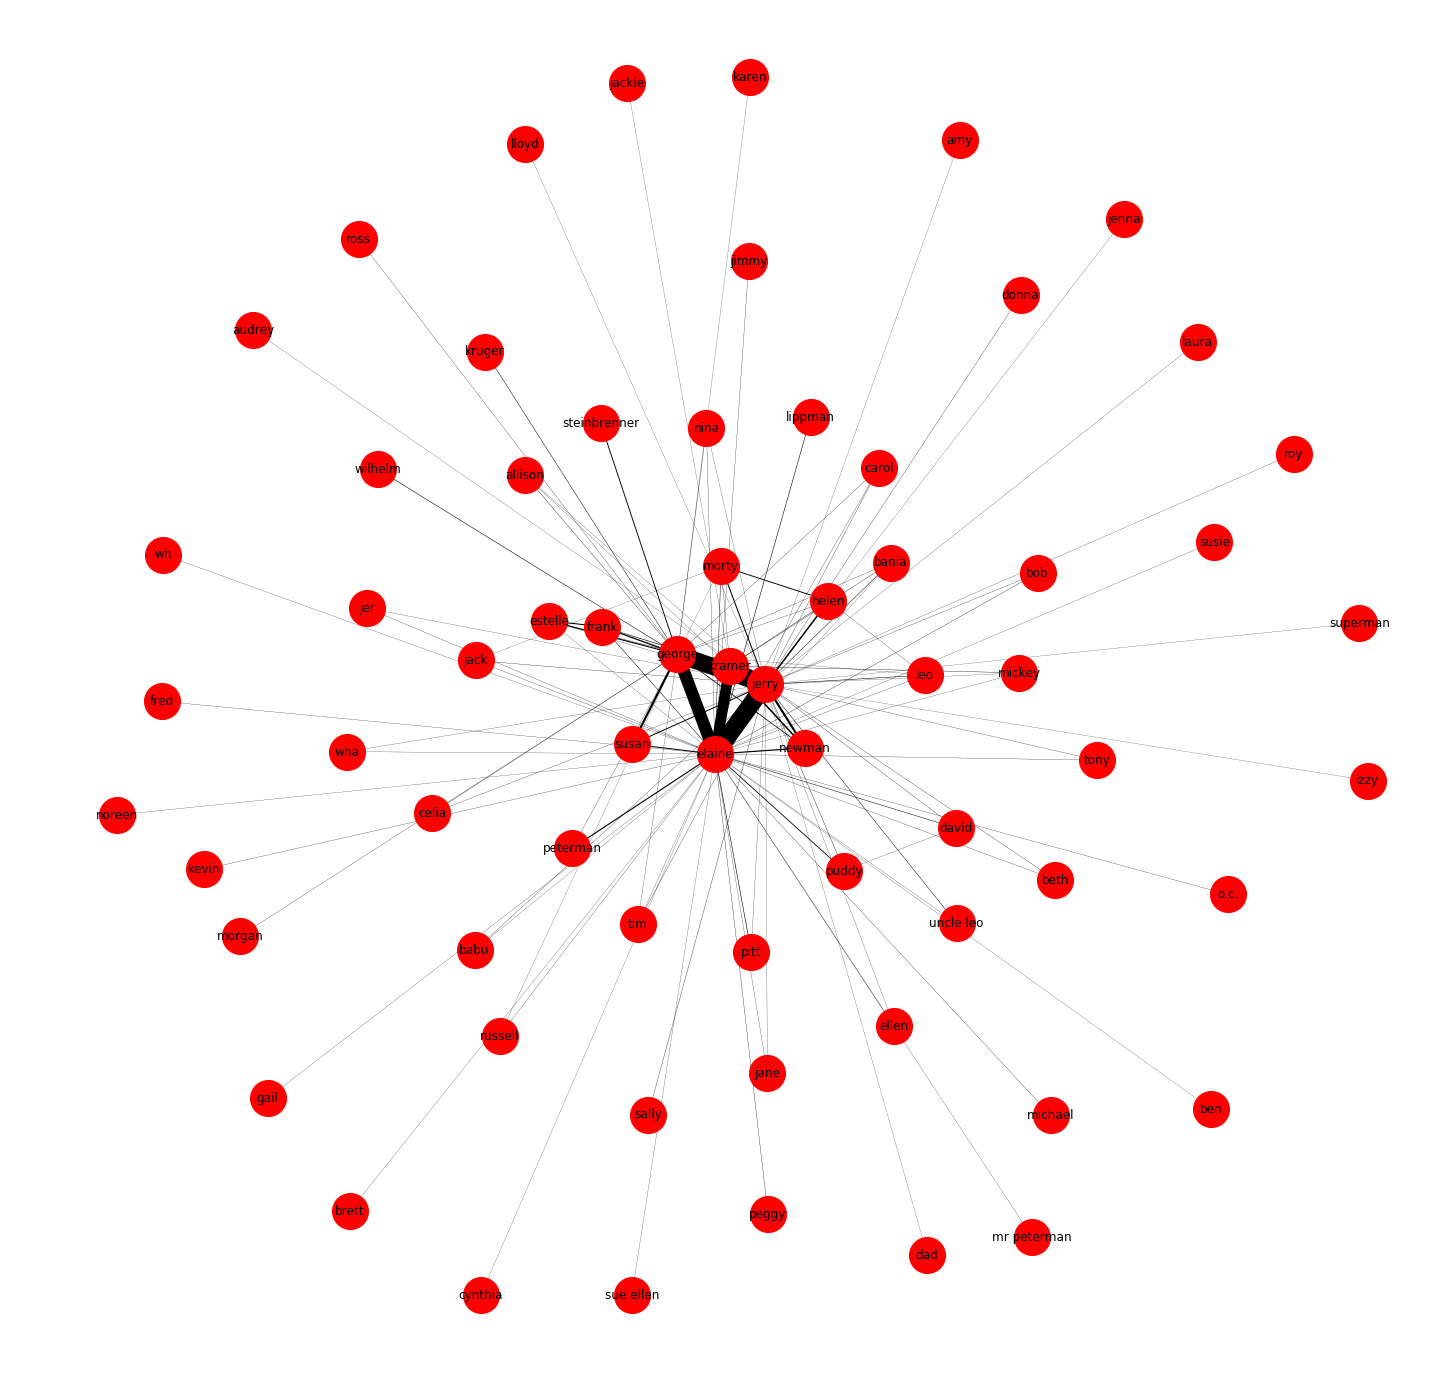

In [191]:
# Plot of the weighted graph. the width of the edge signifies its relative weight.
plt.figure(figsize=(25,25))
pos = nx.spring_layout(g)  # positions for all nodes
nx.draw_networkx_nodes(g, pos, node_size=1300)
weights = [g[u][v]['weight']/50 for u,v in g.edges]

nx.draw(g, pos, edges=g.edges(), with_labels=True, width=weights)

**My Note:**
I decided to regard the top characters as those with the highest degree in the network.

In [205]:
main_characters = [person.upper() for (person, degree) in sorted(dict(g.degree).items(), key=operator.itemgetter(1))[::-1][:10]]
main_characters

['ELAINE',
 'JERRY',
 'GEORGE',
 'KRAMER',
 'MORTY',
 'HELEN',
 'ESTELLE',
 'FRANK',
 'BANIA',
 'NEWMAN']

In [237]:
# list of all the lines spoken in the cript
lines = re.findall('^(.*): (.*)\n', txt, re.MULTILINE)

In [314]:
# SFrame with the text in each line:
charcters = []
text = []
for line in lines:
    if not line[0] in main_characters:
        continue
    charcters.append(line[0])
    char_text = re.sub(r"\((.*)\)", "", line[1])
    text.append(char_text)

sf = tc.SFrame({'character':charcters, 'text':text})
sf

character,text
JERRY,"See, to me, that buttonis in the worst possible ..."
GEORGE,Are you through?
JERRY,"You do of course try on,when you buy? ..."
GEORGE,"Yes, it was purple, Iliked it, I don't ..."
JERRY,"Oh, you don't recall?"
GEORGE,"Uh, no, not at thistime. ..."
JERRY,"Well, senator, I'd justlike to know, what you ..."
GEORGE,"Are, are you sure this isdecaf? Where's the or ..."
JERRY,"Can you relax, it's a cupof coffee. Claire is a ..."
GEORGE,How come you're not doin'the second show tomor ...


Text(0, 0.5, 'number of lines')

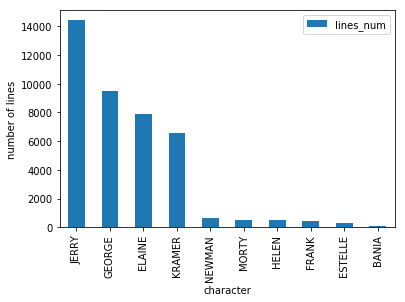

In [315]:
# Plot of the number of lines by character (top 10)
df = sf['character'].value_counts().to_dataframe()
df.columns=['character', 'lines_num']
df.plot.bar(x='character')
plt.ylabel('number of lines')

**Classifier**

In [316]:
afinn = Afinn()
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) # pre-trained word2vec 

def txt2vector(txt):
    # word embedding 
    words = word_tokenize(txt)
    words = [w for w in words if w in model]
    if len(words) != 0:
        return np.mean([model[w] for w in words], axis=0)
    return None

sf = sf.filter_by(classes, 'character')

# create the list of the lines' word embedding
l = []
for i in tqdm(range(len(sf))):
    text = sf[i]["text"]
    l.append(txt2vector(text))
    
classes = ['JERRY', 'ElAINE', 'GEORGE', 'KRAMER']

# Adding the following features to the dataset
sf['word2vec'] = l 
sf['words_dict'] = tc.text_analytics.count_words(sf['text'])
sf['afinn_score'] = sf['text'].apply(lambda t: afinn.score(t))
sf['polarity'] = sf['text'].apply(lambda t: TextBlob(t).sentiment.polarity)
sf['subjectivity'] = sf['text'].apply(lambda t: TextBlob(t).sentiment.subjectivity)
sf['words_1grams'] = tc.text_analytics.count_ngrams(sf['text'], n=1, method='word')
sf['words_2grams'] = tc.text_analytics.count_ngrams(sf['text'], n=2, method='word')
sf = sf.dropna()
sf





  0%|          | 0/30532 [00:00<?, ?it/s]



  0%|          | 1/30532 [00:00<3:28:11,  2.44it/s]



  1%|▏         | 389/30532 [00:00<2:23:55,  3.49it/s]



  2%|▏         | 513/30532 [00:00<1:40:50,  4.96it/s]



  3%|▎         | 838/30532 [00:01<1:09:52,  7.08it/s]



  3%|▎         | 1025/30532 [00:01<48:58, 10.04it/s] 



  4%|▍         | 1361/30532 [00:01<33:56, 14.33it/s]



  5%|▌         | 1549/30532 [00:02<23:57, 20.16it/s]



  6%|▌         | 1905/30532 [00:02<16:36, 28.73it/s]



  7%|▋         | 2112/30532 [00:02<11:52, 39.88it/s]



  8%|▊         | 2482/30532 [00:02<08:14, 56.70it/s]



  9%|▉         | 2701/30532 [00:03<06:03, 76.67it/s]



 10%|█         | 3073/30532 [00:03<04:22, 104.73it/s]



 11%|█▏        | 3456/30532 [00:03<03:03, 147.88it/s]



 12%|█▏        | 3668/30532 [00:04<02:25, 184.79it/s]



 13%|█▎        | 4068/30532 [00:04<01:42, 258.85it/s]



 14%|█▍        | 4301/30532 [00:04<01:26, 302.54it/s]



 15%|█▌        | 4609/30532 [00:05<01:12, 358.9

character,text,word2vec,words_dict,afinn_score
JERRY,"See, to me, that buttonis in the worst possible ...",[ 2.90326793e-023.97944301e-02 ...,"{'your': 1, 'with': 1,'live': 1, 'like': 1, ...",-2.0
GEORGE,Are you through?,[ 0.11893717 0.01261393-0.02659098 0.26334634 ...,"{'through': 1, 'are': 1,'you': 1} ...",0.0
JERRY,"You do of course try on,when you buy? ...",[ 1.16821289e-012.30712891e-02 ...,"{'buy': 1, 'do': 1,'when': 1, 'of': 1, ...",0.0
GEORGE,"Yes, it was purple, Iliked it, I don't ...",[ 0.0657308 0.047570550.03734131 0.1262207 ...,"{'buttons': 1, 'the': 1,'considering': 1, ...",3.0
JERRY,"Oh, you don't recall?",[ 6.85058609e-021.07940674e-01 ...,"{'recall': 1, 't': 1,'don': 1, 'oh': 1, 'y ...",0.0
GEORGE,"Uh, no, not at thistime. ...",[ 3.82893868e-022.25423183e-02 ...,"{'time': 1, 'this': 1,'not': 1, 'at': 1, 'uh': ...",-1.0
JERRY,"Well, senator, I'd justlike to know, what you ...",[ 7.92236328e-027.48211984e-03 ...,"{'it': 1, 'when': 1,'you': 2, 'what': 1, ...",2.0
GEORGE,"Are, are you sure this isdecaf? Where's the or ...",[-1.49397412e-02-3.06021944e-02 ...,"{'indicator': 1, 's': 1,'where': 1, 'are': 2, ...",0.0
JERRY,"Can you relax, it's a cupof coffee. Claire is a ...",[-6.96105976e-03-4.44566719e-02 ...,"{'professional': 1,'claire': 1, 'of': 1, ...",0.0
GEORGE,How come you're not doin'the second show tomor ...,[ 0.08098755 0.034515380.05275879 0.1201416 ...,"{'tomorrow': 1, 'show':1, 'the': 1, 'come': 1, ...",0.0


In [317]:
# Train and test split
train, test = sf.random_split(0.8)
features_list = ['word2vec', 'polarity', 'subjectivity', 'afinn_score', 'words_1grams', 'words_2grams', 'words_dict']

# rain the classifier
cls_seinfeld = tc.classifier.create(train,features=features_list, target="character")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 22969

Number of classes           : 3

Number of feature columns   : 7

Number of unpacked features : 92473

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.423439     | 0.528974          | 0.510566            | 1.056669          | 1.062703            |

| 2         | 0.853332     | 0.537638          | 0.514793            | 1.027444          | 1.039107            |

| 3         | 1.251454     | 0.543776          | 0.520710            | 1.006871          | 1.023170            |

| 4         | 1.637270     | 0.546519          | 0.524091            | 0.990858          | 1.013073            |

| 5         | 2.009745     | 0.550742          | 0.524937            | 0.977894          | 1.006666            |

| 10        | 3.888530     | 0.572641          | 0.528318            | 0.931268          | 0.988653            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 22969

Number of classes           : 3

Number of feature columns   : 7

Number of unpacked features : 92473

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.447290     | 0.527624          | 0.507185            | 0.996940          | 1.017351            |

| 2         | 0.830152     | 0.529888          | 0.516484            | 0.994739          | 1.013980            |

| 3         | 1.226960     | 0.529975          | 0.522401            | 0.993258          | 1.011895            |

| 4         | 1.615000     | 0.528669          | 0.524937            | 0.992964          | 1.010239            |

| 5         | 2.025458     | 0.527581          | 0.528318            | 0.992518          | 1.010664            |

| 10        | 3.995911     | 0.527755          | 0.521555            | 0.991041          | 1.008736            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 22969

Number of classes           : 3

Number of feature columns   : 7

Number of unpacked features : 92473

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.451160     | 0.528974          | 0.510566            | 0.995188          | 1.015723            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 22969

Number of classes           : 3

Number of feature columns   : 7

Number of unpacked features : 92473

Number of coefficients      : 184948

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 5        | 0.052086  | 0.361894     | 0.478166          | 0.491124            |

| 1         | 10       | 4.427304  | 1.405497     | 0.722800          | 0.521555            |

| 2         | 11       | 4.427304  | 2.068221     | 0.816013          | 0.504649            |

| 3         | 12       | 4.427304  | 2.757224     | 0.597893          | 0.337278            |

| 4         | 18       | 1.389210  | 3.835011     | 0.864861          | 0.476754            |

| 9         | 27       | 1.000000  | 7.633815     | 0.902477          | 0.454776            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.5283178360101437
PROGRESS: RandomForestClassifier          : 0.5215553677092138
PROGRESS: DecisionTreeClassifier          : 0.5105663567202029
PROGRESS: LogisticClassifier              : 0.4547759932375317
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [325]:
# evaluate on the test set
scores = cls_seinfeld.evaluate(test)
scores

{'accuracy': 0.501505016722408,
 'auc': 0.6233436939644678,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 9
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |    JERRY     |      KRAMER     |   83  |
 |    GEORGE    |      JERRY      |  1625 |
 |    KRAMER    |      GEORGE     |   86  |
 |    KRAMER    |      JERRY      |  997  |
 |    GEORGE    |      GEORGE     |  192  |
 |    KRAMER    |      KRAMER     |  194  |
 |    GEORGE    |      KRAMER     |   93  |
 |    JERRY     |      GEORGE     |   97  |
 |    JERRY     |      JERRY      |  2613 |
 +--------------+-----------------+-------+
 [9 rows x 3 columns],
 'f1_score': 0.35153465265023015,
 'log_loss': 1.00179866191861,
 'precision': 0.5118215751568187,
 'recall': 0.3959984293227479,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 	class	int
 
 Rows: 300003
 
 